In [10]:
# scripts/generate_dataset.py
import chess, random
import numpy as np
import pandas as pd
from stockfish import Stockfish
from tqdm import tqdm
import os

# === Configuration ===
OUT_DIR = os.path.abspath(os.path.join(".", "data"))
os.makedirs(OUT_DIR, exist_ok=True)
CSV_PATH = os.path.join(OUT_DIR, "positions.csv")
EMB_PATH = os.path.join(OUT_DIR, "embeddings.npy")
SCORES_PATH = os.path.join(OUT_DIR, "scores.npy")

SAMPLES = 20000         # change to 100k+ for larger datasets
MAX_MOVES = 40          # how deep to random-play to get variability
STOCKFISH_PATH = "/opt/homebrew/bin/stockfish"  # change if needed
STOCKFISH_DEPTH = 12    # depth to evaluate each position

# === helper: board -> 768-dim vector ===
piece_to_index = {
    'P':0,'N':1,'B':2,'R':3,'Q':4,'K':5,
    'p':6,'n':7,'b':8,'r':9,'q':10,'k':11
}

def board_to_vector(board):
    vec = np.zeros((8,8,12), dtype=np.float32)
    for sq in chess.SQUARES:
        piece = board.piece_at(sq)
        if piece:
            r, c = divmod(sq, 8)
            vec[r, c, piece_to_index[piece.symbol()]] = 1
    return vec.flatten()

# === Stockfish setup ===
stockfish = Stockfish(path=STOCKFISH_PATH)
# Set skill & threads if wanted:
# stockfish.update_engine_parameters({"Threads": 2})

def evaluate_board_with_stockfish(board):
    stockfish.set_fen_position(board.fen())
    stockfish.set_depth(STOCKFISH_DEPTH)
    eval_info = stockfish.get_evaluation()
    # 'value' is centipawns, 'mate' if mate found
    if eval_info["type"] == "cp":
        return float(eval_info["value"])
    else:
        # convert mate to large magnitude number with sign
        mate = eval_info["value"]
        return 10000.0 * (-1 if mate < 0 else 1)  # big number

# === generate random legal positions ===
positions = []
embeddings = []
scores = []

for _ in tqdm(range(SAMPLES), desc="Generating"):
    board = chess.Board()
    # play random legal moves
    moves = random.randint(0, MAX_MOVES)
    for _ in range(moves):
        if board.is_game_over():
            break
        mv = random.choice(list(board.legal_moves))
        board.push(mv)
    # optionally skip trivial positions
    positions.append(board.fen())
    embeddings.append(board_to_vector(board))
    scores.append(evaluate_board_with_stockfish(board))

# Save
df = pd.DataFrame({"fen": positions, "score": scores})
df.to_csv(CSV_PATH, index=False)
np.save(EMB_PATH, np.array(embeddings, dtype=np.float32))
np.save(SCORES_PATH, np.array(scores, dtype=np.float32))

print("Saved:", CSV_PATH, EMB_PATH, SCORES_PATH)


Generating: 100%|█████████████████████████| 20000/20000 [06:24<00:00, 52.03it/s]


Saved: /Users/prathameshswar/Downloads/COMP580/data/positions.csv /Users/prathameshswar/Downloads/COMP580/data/embeddings.npy /Users/prathameshswar/Downloads/COMP580/data/scores.npy


In [26]:
import chess
import numpy as np
import pandas as pd

df = pd.read_csv("data/positions.csv")

# Define board encoder
def board_to_vector(fen):
    board = chess.Board(fen)
    planes = np.zeros((12, 8, 8), dtype=np.int8)
    piece_map = board.piece_map()

    for square, piece in piece_map.items():
        piece_type = piece.piece_type - 1  # 0-5
        color_offset = 0 if piece.color == chess.WHITE else 6
        planes[piece_type + color_offset, square // 8, square % 8] = 1

    return planes.flatten()

# Apply to all rows
vectors = np.vstack([board_to_vector(fen) for fen in df['fen']])
y = df['score'].values

print("Feature matrix shape:", vectors.shape)
print("Example vector:", vectors[0][:20])


Feature matrix shape: (20000, 768)
Example vector: [0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0]


In [29]:
import pandas as pd
import numpy as np
import chess

# Load your dataset
df = pd.read_csv("data/positions.csv")

# Define the piece order for bitboard encoding
pieces = ['P','N','B','R','Q','K','p','n','b','r','q','k']

def fen_to_vector(fen):
    """
    Convert a FEN string into a flattened 8x8x12 one-hot vector
    """
    board = chess.Board(fen)
    vector = np.zeros((8,8,12), dtype=np.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            piece_index = pieces.index(piece.symbol())
            row, col = divmod(square, 8)
            vector[row, col, piece_index] = 1
    return vector.flatten()

# Convert all FENs to vectors
df['vector'] = df['fen'].apply(fen_to_vector)

# Rename 'score' to 'eval'
df.rename(columns={'score':'eval'}, inplace=True)

# Create feature and label arrays
X = np.vstack(df['vector'].values)
y = df['eval'].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (20000, 768)
y shape: (20000,)


In [30]:
import faiss

d = X.shape[1]
index = faiss.IndexFlatL2(d)
index.add(X.astype('float32'))

query = X[0:1]
D, I = index.search(query.astype('float32'), k=5)
print("Nearest neighbors:", I)
print("Distances:", D)


Nearest neighbors: [[    0  2322 13385  2103  3266]]
Distances: [[ 0. 14. 14. 16. 16.]]


In [33]:
import faiss

# Build exact L2 index
d = X.shape[1]  # dimension of vectors
index = faiss.IndexFlatL2(d)
index.add(X.astype('float32'))

print("FAISS index built with", index.ntotal, "positions")

# Test a query: find k nearest neighbors
k = 5
query_vec = X[0:1].astype('float32')  # example query
D, I = index.search(query_vec, k)

print("Indices of nearest neighbors:", I)
print("Distances:", D)
print("Stockfish evals of neighbors:", y[I])

# Define a function to estimate win probability
def estimate_win_prob(query_vec, k=10):
    D, I = index.search(query_vec.reshape(1, -1).astype('float32'), k)
    return np.mean(y[I])

# Test the win probability estimate
example_query = X[100]
print("Estimated win probability:", estimate_win_prob(example_query))

# Benchmark query speed
import time

N = 100
start = time.time()
for _ in range(N):
    q = X[np.random.randint(len(X))].reshape(1, -1).astype('float32')
    index.search(q, k)
end = time.time()
print(f"Average query time: {(end - start)/N * 1000:.4f} ms per query")


FAISS index built with 20000 positions
Indices of nearest neighbors: [[    0  2322 13385  2103  3266]]
Distances: [[ 0. 14. 14. 16. 16.]]
Stockfish evals of neighbors: [[-208  266  -34  -15   55]]
Estimated win probability: -103.8
Average query time: 1.3686 ms per query


In [34]:
# Build an LSH index
num_bits = 128  # number of hash bits, can tune
index_lsh = faiss.IndexLSH(d, num_bits)
index_lsh.add(X.astype('float32'))

print("LSH index built with", index_lsh.ntotal, "positions")

# Test a query on LSH index
k = 5
query_vec = X[0:1].astype('float32')
D_lsh, I_lsh = index_lsh.search(query_vec, k)

print("LSH nearest neighbors indices:", I_lsh)
print("LSH distances:", D_lsh)
print("Stockfish evals of LSH neighbors:", y[I_lsh])

# Function to estimate win probability using LSH
def estimate_win_prob_lsh(query_vec, k=10):
    D, I = index_lsh.search(query_vec.reshape(1, -1).astype('float32'), k)
    return np.mean(y[I])

# Test example query
example_query = X[100]
print("Estimated win probability (LSH):", estimate_win_prob_lsh(example_query))

# Benchmark LSH query speed
import time

N = 100
start = time.time()
for _ in range(N):
    q = X[np.random.randint(len(X))].reshape(1, -1).astype('float32')
    index_lsh.search(q, k)
end = time.time()
print(f"Average LSH query time: {(end - start)/N * 1000:.4f} ms per query")


LSH index built with 20000 positions
LSH nearest neighbors indices: [[    0 15129  8748  7812 10638]]
LSH distances: [[ 0. 14. 16. 18. 18.]]
Stockfish evals of LSH neighbors: [[-208  -41    8   14  175]]
Estimated win probability (LSH): -195.7
Average LSH query time: 0.0896 ms per query


In [35]:
def centipawn_to_prob(cp):
    """
    Convert centipawn eval to probability of White winning.
    cp = Stockfish eval in centipawns (+ = White, - = Black)
    """
    import numpy as np
    return 1 / (1 + np.exp(-cp / 200))  # 200 is a scaling factor; tune as needed

def estimate_win_prob_lsh(query_vec, k=10):
    D, I = index_lsh.search(query_vec.reshape(1, -1).astype('float32'), k)
    avg_cp = np.mean(y[I])
    return centipawn_to_prob(avg_cp)

example_query = X[100]
print("Estimated win probability (White):", estimate_win_prob_lsh(example_query))


Estimated win probability (White): 0.27318951781696127


In [36]:
import numpy as np

k = 10  # number of neighbors to compare
num_queries = 100  # number of random queries to test

recalls = []
mae_probs = []

for _ in range(num_queries):
    idx = np.random.randint(len(X))
    query_vec = X[idx:idx+1].astype('float32')
    
    # Exact neighbors
    D_exact, I_exact = index.search(query_vec, k)
    
    # LSH neighbors
    D_lsh, I_lsh = index_lsh.search(query_vec, k)
    
    # --- Recall ---
    true_set = set(I_exact[0])
    lsh_set = set(I_lsh[0])
    recall = len(true_set & lsh_set) / k
    recalls.append(recall)
    
    # --- Win probability accuracy ---
    exact_prob = centipawn_to_prob(np.mean(y[I_exact]))
    lsh_prob = centipawn_to_prob(np.mean(y[I_lsh]))
    mae = abs(exact_prob - lsh_prob)
    mae_probs.append(mae)

# --- Results ---
print(f"Average recall over {num_queries} queries: {np.mean(recalls):.3f}")
print(f"Average MAE of win probability estimates: {np.mean(mae_probs):.3f}")


Average recall over 100 queries: 0.264
Average MAE of win probability estimates: 0.148


Average recall (LSH): 0.238
Average MAE (win probability): 0.180
Average query time (Exact): 1.603 ms
Average query time (LSH): 0.166 ms


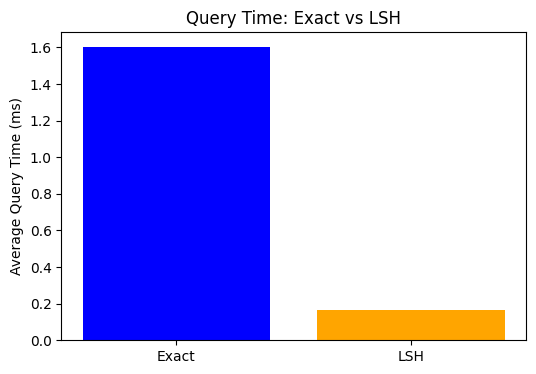

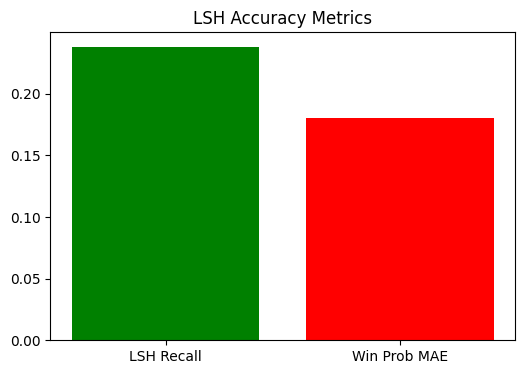

In [37]:
import time
import numpy as np
import matplotlib.pyplot as plt

k = 10  # neighbors
num_queries = 100  # number of random queries

# Containers
recalls = []
mae_probs = []
exact_times = []
lsh_times = []

# Function to convert Stockfish eval to probability
def centipawn_to_prob(cp):
    return 1 / (1 + np.exp(-cp / 200))

# --- Benchmark ---
for _ in range(num_queries):
    idx = np.random.randint(len(X))
    query_vec = X[idx:idx+1].astype('float32')
    
    # --- Exact search ---
    start = time.time()
    D_exact, I_exact = index.search(query_vec, k)
    exact_times.append(time.time() - start)
    
    # --- LSH search ---
    start = time.time()
    D_lsh, I_lsh = index_lsh.search(query_vec, k)
    lsh_times.append(time.time() - start)
    
    # --- Recall ---
    recall = len(set(I_exact[0]) & set(I_lsh[0])) / k
    recalls.append(recall)
    
    # --- Win probability MAE ---
    exact_prob = centipawn_to_prob(np.mean(y[I_exact]))
    lsh_prob = centipawn_to_prob(np.mean(y[I_lsh]))
    mae_probs.append(abs(exact_prob - lsh_prob))

# --- Results ---
avg_recall = np.mean(recalls)
avg_mae = np.mean(mae_probs)
avg_exact_time = np.mean(exact_times) * 1000  # ms
avg_lsh_time = np.mean(lsh_times) * 1000      # ms

print(f"Average recall (LSH): {avg_recall:.3f}")
print(f"Average MAE (win probability): {avg_mae:.3f}")
print(f"Average query time (Exact): {avg_exact_time:.3f} ms")
print(f"Average query time (LSH): {avg_lsh_time:.3f} ms")

# --- Visualization ---
plt.figure(figsize=(6,4))
plt.bar(['Exact', 'LSH'], [avg_exact_time, avg_lsh_time], color=['blue','orange'])
plt.ylabel("Average Query Time (ms)")
plt.title("Query Time: Exact vs LSH")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(['LSH Recall', 'Win Prob MAE'], [avg_recall, avg_mae], color=['green','red'])
plt.title("LSH Accuracy Metrics")
plt.show()
